In [5]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.utils.data import DataLoader







In [6]:
data_url    = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1"
zip_path    = tf.keras.utils.get_file("EuroSAT_RGB.zip", data_url, extract=False)
extract_dir = os.path.join(os.path.dirname(zip_path), "EuroSAT_RGB")

# If the extraction directory does not exist, unzip the archive
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(os.path.dirname(zip_path))


94658721/94658721 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [7]:
batch_size = 32
img_size   = (64, 64)

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    extract_dir,
    labels="inferred",         # Infer labels from subdirectory names
    label_mode="int",          # Return integer labels
    validation_split=0.30,     # Use 30% of data for validation+test
    subset="training",         # This dataset will be the 70% training split
    seed=123,                  # Seed for shuffling and splitting
    image_size=img_size,       # Resize images to 64×64
    batch_size=batch_size,
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    extract_dir,
    labels="inferred",         # Infer labels from subdirectory names
    label_mode="int",          # Return integer labels
    validation_split=0.30,     # Use 30% of data for this subset
    subset="validation",       # This dataset will be the 30% validation+test split
    seed=123,                  # Same seed to ensure consistent split
    image_size=img_size,       # Resize images to 64×64
    batch_size=batch_size,
)

# Split the 30% subset into 50% validation and 50% test
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds       = val_test_ds.take(val_batches)  # First half for validation
test_ds      = val_test_ds.skip(val_batches)  # Remaining half for test

print(f"  • train batches: {tf.data.experimental.cardinality(raw_train_ds).numpy()}")
print(f"  •   val batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"  •  test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 27000 files belonging to 10 classes.
Using 18900 files for training.
Found 27000 files belonging to 10 classes.
Using 8100 files for validation.
  • train batches: 591
  •   val batches: 127
  •  test batches: 127


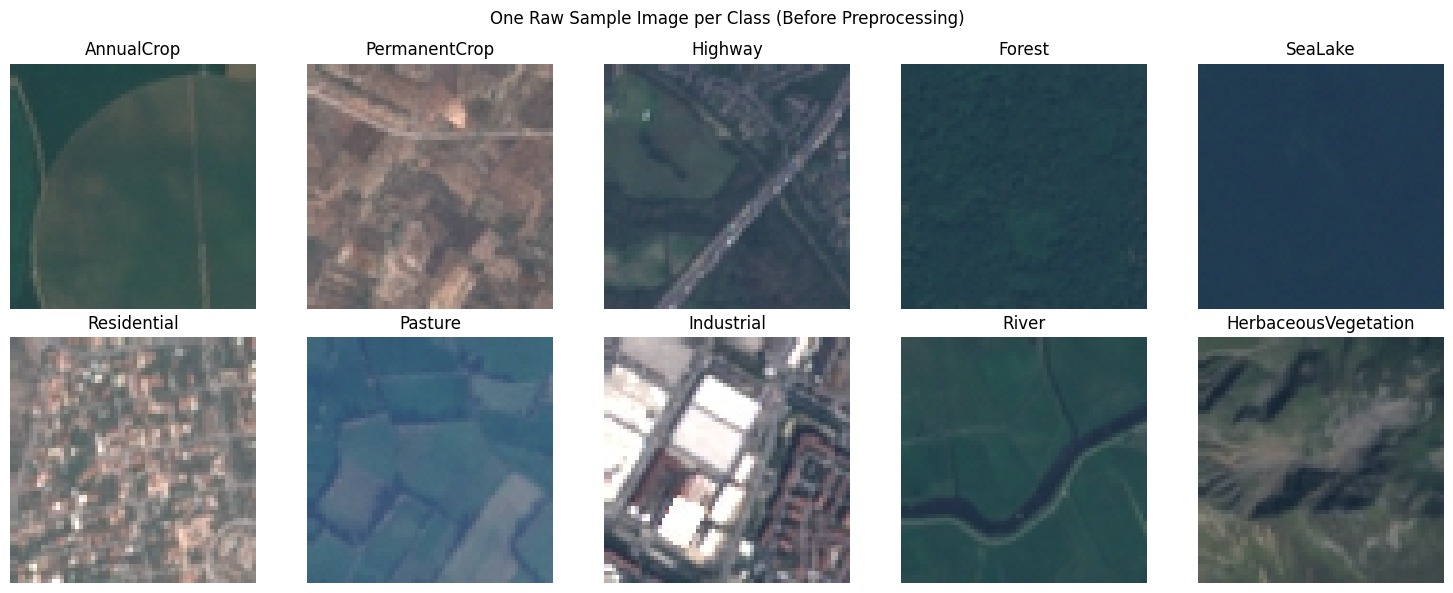

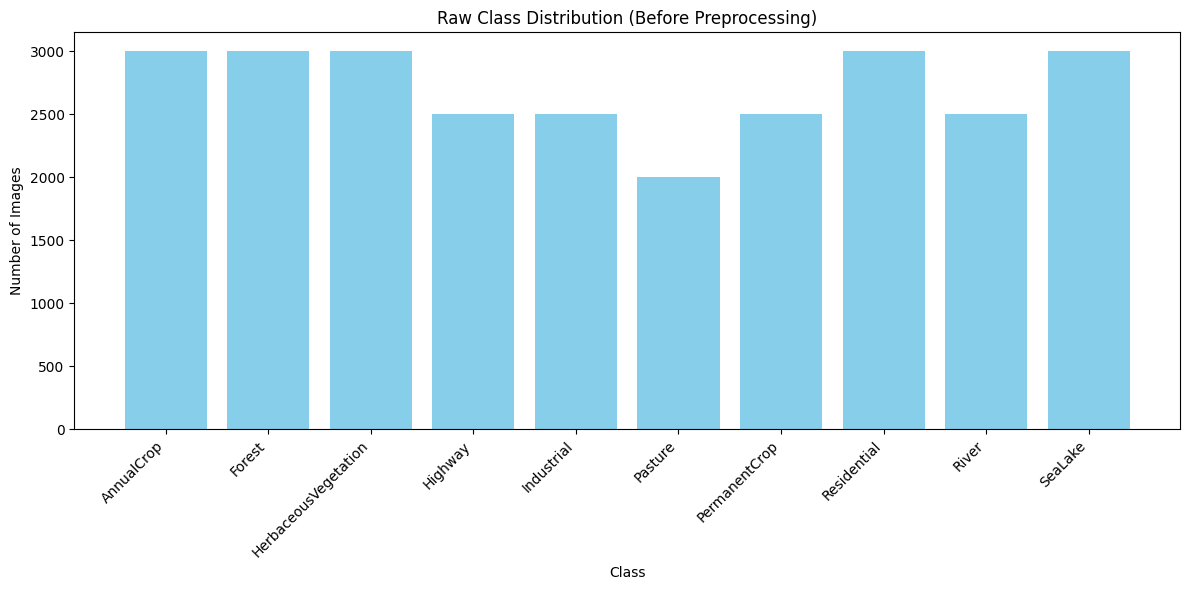

In [8]:
class_names = raw_train_ds.class_names
sampled_images = {}
plt.figure(figsize=(15, 6))

# Iterate through raw_train_ds.unbatch() to get (image, label) pairs
# raw_train_ds yields images with dtype=uint8 in [0,255]
for image, label in raw_train_ds.unbatch():
    label_idx = int(label.numpy())
    cls_name  = class_names[label_idx]
    if cls_name not in sampled_images:
        # Convert the image tensor to numpy array for display
        img_np = image.numpy().astype("uint8")
        sampled_images[cls_name] = img_np
    if len(sampled_images) == len(class_names):
        break

# Plot the collected images in a grid (2 rows × 5 columns)
num_classes = len(class_names)
cols        = 5
rows        = int(np.ceil(num_classes / cols))
for idx, (cls_name, img) in enumerate(sampled_images.items()):
    ax = plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(cls_name)
    plt.axis("off")

plt.suptitle("One Raw Sample Image per Class (Before Preprocessing)")
plt.tight_layout()
plt.show()


# Plot the number of images per class BEFORE any preprocessing
class_counts = {}
for cls in class_names:
    cls_dir = os.path.join(extract_dir, cls)
    # Count only image files with extensions .jpg, .jpeg, .png
    count = len([
        fname for fname in os.listdir(cls_dir)
        if fname.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    class_counts[cls] = count

# Bar chart of class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Raw Class Distribution (Before Preprocessing)")
plt.tight_layout()
plt.show()

In [9]:
#Define PyTorch data transforms (augmentation + normalization)

# Normalize [0,255]→[0,1]→[-1,1]
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                 std=(0.5, 0.5, 0.5))

# Training augmentations: random flip, rotation, zoom
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    normalize
])

# Validation/Test: only resizing + normalization
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])


# Prepare PyTorch ImageFolder dataset and split 70/15/15

full_dataset = datasets.ImageFolder(root=extract_dir,
                                    transform=train_transform)

# Compute split lengths
total_count     = len(full_dataset)  # total images across all classes
train_count     = int(0.70 * total_count)
val_count       = int(0.15 * total_count)
test_count      = total_count - train_count - val_count

# Use a fixed seed for reproducibility
train_data, val_data, test_data = random_split(
    full_dataset,
    [train_count, val_count, test_count],
    generator=torch.Generator().manual_seed(123)
)

# Replace transform for validation and test subsets
# (random_split returns Subset, so dataset = full_dataset internally)
val_data.dataset.transform  = val_test_transform
test_data.dataset.transform = val_test_transform


#  Create DataLoaders
batch_size = 32

train_loader      = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
validation_loader = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader       = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:

# Define a PyTorch CNN model for EuroSAT (64×64×3 input)

class EuroSAT_CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_conv=0.25, dropout_fc=0.3):
        super(EuroSAT_CNN, self).__init__()
        # Feature extractor: 3 convolutional blocks (Conv → ReLU → Conv → ReLU → MaxPool → Dropout)
        self.features = nn.Sequential(
            # Block 1: Input (3, 64, 64)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # → (32, 64, 64)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # → (32, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # → (32, 32, 32)
            nn.Dropout2d(p=dropout_conv),

            # Block 2: Input (32, 32, 32)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # → (64, 32, 32)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # → (64, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # → (64, 16, 16)
            nn.Dropout2d(p=dropout_conv),

            # Block 3: Input (64, 16, 16)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),# → (128, 16, 16)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),# → (128, 16, 16)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # → (128, 8, 8)
            nn.Dropout2d(p=dropout_conv)
        )

        # Classifier: Flatten → FC(256) → ReLU → Dropout → FC(num_classes)
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # → (128 * 8 * 8) = (8192,)
            nn.Linear(in_features=128 * 8 * 8, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_fc),
            nn.Linear(in_features=256, out_features=num_classes)  # logits for each class
        )

    def forward(self, x):
        """
        Forward pass returns:
          - logits: raw class scores of shape (batch_size, num_classes)
          - last_conv: the feature maps after the final Conv block (batch_size, 128, 8, 8)
        """
        x = self.features(x)
        last_conv = x
        logits = self.classifier(x)
        return logits, last_conv



# Instantiate the model and print a summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eurosat_model = EuroSAT_CNN(num_classes=10).to(device)

# Use torchsummary to display the model architecture and parameter counts
summary(eurosat_model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
         Dropout2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
             ReLU-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 16, 16]               0
        Dropout2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
             ReLU-14          [-1, 128,

Epoch 1/30 — Train Loss (train mode): 1.5263, Train Loss (eval mode): 1.1639, Val Loss: 1.1743
Validation loss decreased (1.174345 → 1.174345). Saving model ...
Epoch 2/30 — Train Loss (train mode): 1.0972, Train Loss (eval mode): 0.8059, Val Loss: 0.8152
Validation loss decreased (1.174345 → 0.815208). Saving model ...
Epoch 3/30 — Train Loss (train mode): 0.9007, Train Loss (eval mode): 0.6581, Val Loss: 0.6912
Validation loss decreased (0.815208 → 0.691230). Saving model ...
Epoch 4/30 — Train Loss (train mode): 0.7853, Train Loss (eval mode): 0.5898, Val Loss: 0.6301
Validation loss decreased (0.691230 → 0.630058). Saving model ...
Epoch 5/30 — Train Loss (train mode): 0.6858, Train Loss (eval mode): 0.5582, Val Loss: 0.6202
Validation loss decreased (0.630058 → 0.620227). Saving model ...
Epoch 6/30 — Train Loss (train mode): 0.6188, Train Loss (eval mode): 0.4097, Val Loss: 0.4969
Validation loss decreased (0.620227 → 0.496941). Saving model ...
Epoch 7/30 — Train Loss (train mod

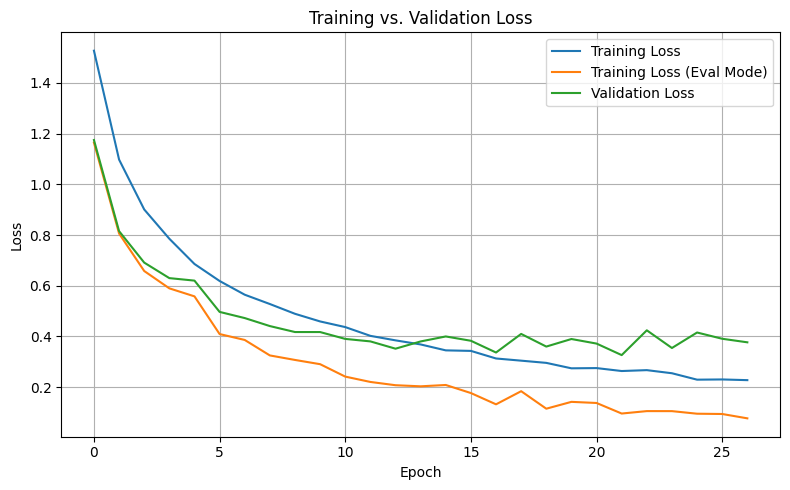

Test Loss: 0.3500
Test Accuracy: 88.20%


In [11]:



# Define EarlyStopping and training function (reuse earlier definitions)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001, path='checkpoint.pt'):
        """
        Args:
            patience (int): Epochs to wait after last validation improvement.
            min_delta (float): Minimum change to qualify as improvement.
            path (str): File path to save the best model.
        """
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False
        self.path       = path

    def __call__(self, val_loss, model):
        """
        Call at end of each epoch to check for early stopping.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter   = 0

    def save_checkpoint(self, val_loss, model):
        """
        Save model weights when validation loss decreases.
        """
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} → {val_loss:.6f}). Saving model ...')


def train_cnn_model(epochs, model, optimizer, criterion,
                    train_loader, val_loader, early_stopper, device):
    """
    Train the CNN with early stopping, and also compute training loss
    under evaluation mode (dropout and augmentations off) for comparison.
    Returns:
      train_losses (list of float): avg training loss in train() mode per epoch
      train_eval_losses (list of float): avg training loss in eval() mode per epoch
      val_losses (list of float): avg validation loss per epoch
    """
    train_losses = []
    train_eval_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ------ Training Loop (train mode: dropout/augmentation on) ------
        model.train()
        running_train_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            logits, _ = model(data)             # model.train(): dropout/augment active
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------ Compute Training Loss in Eval Mode (dropout/augmentation off) ------
        model.eval()
        running_train_eval_loss = 0.0
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                logits, _ = model(data)         # model.eval(): dropout inactive
                loss = criterion(logits, target)
                running_train_eval_loss += loss.item()

        avg_train_eval_loss = running_train_eval_loss / len(train_loader)
        train_eval_losses.append(avg_train_eval_loss)

        # ------ Validation Loop (eval mode) ------
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                logits, _    = model(data)
                loss         = criterion(logits, target)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print all three losses for monitoring
        print(
            f"Epoch {epoch+1}/{epochs} — "
            f"Train Loss (train mode): {avg_train_loss:.4f}, "
            f"Train Loss (eval mode): {avg_train_eval_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}"
        )

        # ------ Early Stopping Check ------
        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model checkpoint before returning
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, train_eval_losses, val_losses



# Instantiate model, criterion, optimizer, early stopping

device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eurosat_model.to(device)

criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(eurosat_model.parameters(), lr=0.001, weight_decay=0.0001)
early_stopper = EarlyStopping(patience=5, min_delta=0.0001, path='eurosat_best.pt')


# Train the model

epochs = 30
train_losses, train_eval_losses, val_losses = train_cnn_model(
    epochs,
    eurosat_model,
    optimizer,
    criterion,
    train_loader,
    validation_loader,
    early_stopper,
    device
)


# Plot training and validation loss curves

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_eval_losses, label='Training Loss (Eval Mode)')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluate the best model on the test set

eurosat_model.eval()
test_loss  = 0.0
correct    = 0
total      = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logits, _    = eurosat_model(data)
        loss         = criterion(logits, target)
        test_loss   += loss.item()
        preds        = logits.argmax(dim=1)
        correct     += (preds == target).sum().item()
        total       += target.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc      = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Macro-Averaged F1 Score: 0.8781

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.8747    0.8805    0.8776       452
              Forest     0.9353    0.9886    0.9612       439
HerbaceousVegetation     0.8259    0.8009    0.8132       462
             Highway     0.8536    0.7527    0.8000       364
          Industrial     0.9412    0.9167    0.9288       384
             Pasture     0.8746    0.8123    0.8423       309
       PermanentCrop     0.7500    0.7975    0.7730       395
         Residential     0.9148    0.9713    0.9422       453
               River     0.8470    0.8732    0.8599       355
             SeaLake     0.9862    0.9794    0.9828       437

            accuracy                         0.8820      4050
           macro avg     0.8803    0.8773    0.8781      4050
        weighted avg     0.8820    0.8820    0.8813      4050

Confusion Matrix:
[[398   2   5   2   0  14  14   0  13   4]
 [  0 434   

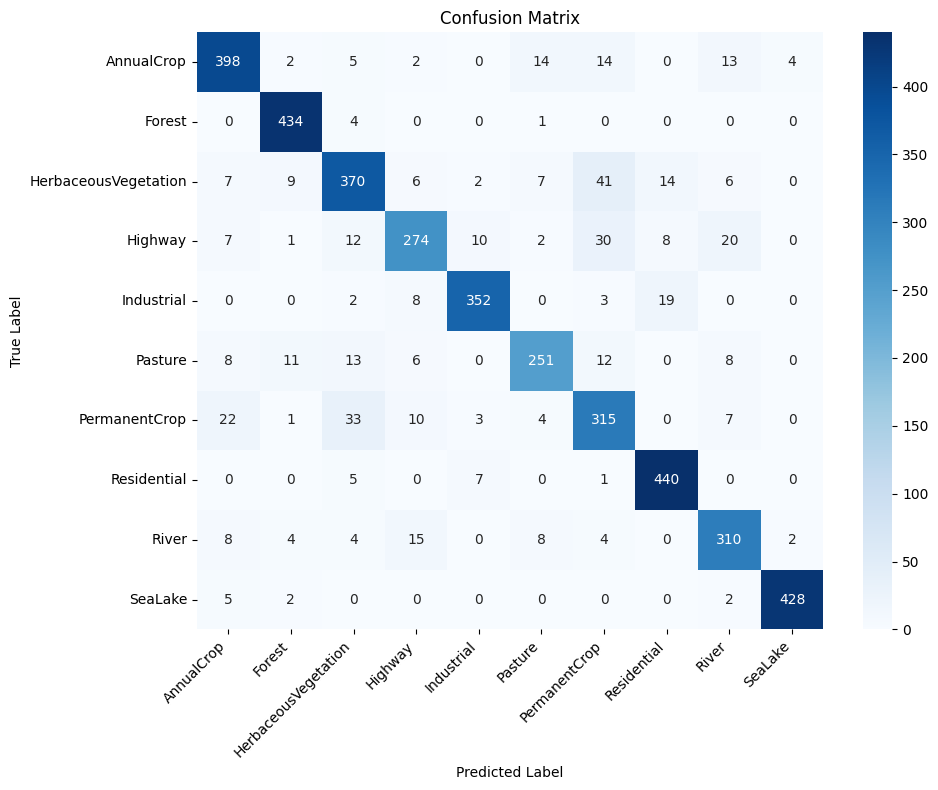

In [12]:

# Evaluate on test set and compute F1 score, classification report, confusion matrix


# Make sure the correct model variable is used (eurosat_model)
eurosat_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logits, _    = eurosat_model(data)
        preds        = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(target.cpu().numpy())

# Concatenate all batches
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Compute overall F1 score (macro-averaged)
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1_macro:.4f}\n")

# Classification report: precision, recall, f1-score per class
class_names = full_dataset.classes  # Ensure this matches the order used by ImageFolder
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


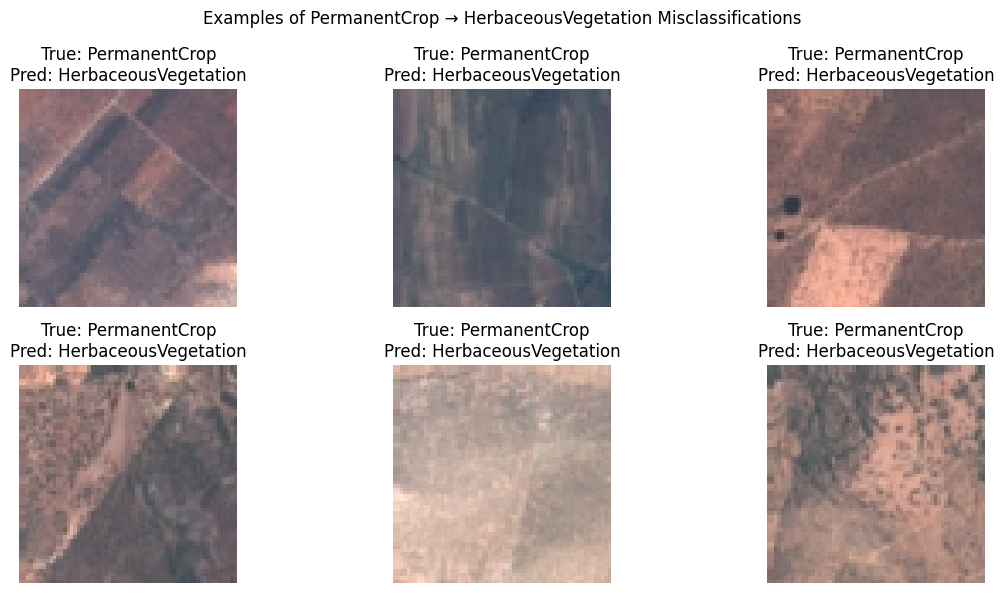

In [13]:

# Ensure model is in evaluation mode
eurosat_model.eval()

# Identify the integer indices for the classes
true_class_name  = "PermanentCrop"
pred_class_name  = "HerbaceousVegetation"
class_names      = full_dataset.classes  # List of class names in order
true_idx  = class_names.index(true_class_name)
pred_idx  = class_names.index(pred_class_name)

misclassified_images = []
misclassified_labels = []  # store (true, pred) tuples, if needed

# Loop over the test set and collect misclassified examples
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits, _ = eurosat_model(images)
        preds = logits.argmax(dim=1)

        # Find positions where true==PermanentCrop but pred==HerbaceousVegetation
        mask = (labels == true_idx) & (preds == pred_idx)
        if mask.any():
            # For each misclassified item in the batch, store its tensor
            for img_tensor, is_mis in zip(images, mask):
                if is_mis:
                    misclassified_images.append(img_tensor.cpu())
                    misclassified_labels.append((true_idx, pred_idx))

        # Stop once we've collected enough examples
        if len(misclassified_images) >= 6:
            break

# If no misclassifications found
if len(misclassified_images) == 0:
    print(f"No examples found where true label is '{true_class_name}' but predicted as '{pred_class_name}'.")
else:
    # Display up to 6 misclassified images
    num_to_show = min(len(misclassified_images), 6)
    plt.figure(figsize=(12, 6))
    for i in range(num_to_show):
        img = misclassified_images[i]
        # Undo normalization: original normalization was (x - 0.5) / 0.5 → x = img * 0.5 + 0.5
        img_disp = img.numpy().transpose(1, 2, 0) * 0.5 + 0.5
        img_disp = np.clip(img_disp, 0, 1)

        ax = plt.subplot(2, 3, i + 1)
        ax.imshow(img_disp)
        ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}")
        ax.axis("off")

    plt.suptitle(f"Examples of {true_class_name} → {pred_class_name} Misclassifications")
    plt.tight_layout()
    plt.show()


# Bonus Task 1

Epoch 1/30 — Train Loss: 2.0256, Val Loss: 1.7721
Validation loss decreased (1.772101 → 1.772101). Saving model ...
Epoch 2/30 — Train Loss: 1.8635, Val Loss: 1.7955
Epoch 3/30 — Train Loss: 1.8339, Val Loss: 1.6513
Validation loss decreased (1.772101 → 1.651293). Saving model ...
Epoch 4/30 — Train Loss: 1.8345, Val Loss: 1.7287
Epoch 5/30 — Train Loss: 1.8482, Val Loss: 1.7200
Epoch 6/30 — Train Loss: 1.8112, Val Loss: 1.6988
Epoch 7/30 — Train Loss: 1.7986, Val Loss: 1.6719
Epoch 8/30 — Train Loss: 1.8018, Val Loss: 1.6604
MLP Early stopping triggered.


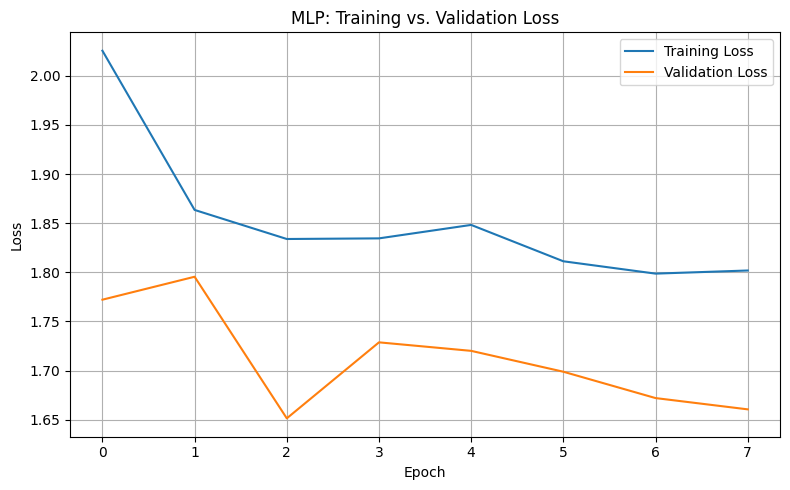

MLP Test Loss: 1.6475
MLP Test Accuracy: 38.10%

MLP Macro-Averaged F1 Score: 0.3283

MLP Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.4467    0.4912    0.4679       452
              Forest     0.2743    0.9704    0.4277       439
HerbaceousVegetation     0.3504    0.4156    0.3802       462
             Highway     0.2500    0.0027    0.0054       364
          Industrial     0.7127    0.8594    0.7792       384
             Pasture     0.4507    0.1036    0.1684       309
       PermanentCrop     0.4069    0.1494    0.2185       395
         Residential     0.3154    0.2583    0.2840       453
               River     0.3109    0.2338    0.2669       355
             SeaLake     0.6183    0.1854    0.2852       437

            accuracy                         0.3810      4050
           macro avg     0.4136    0.3670    0.3283      4050
        weighted avg     0.4129    0.3810    0.3364      4050

MLP Confusion Ma

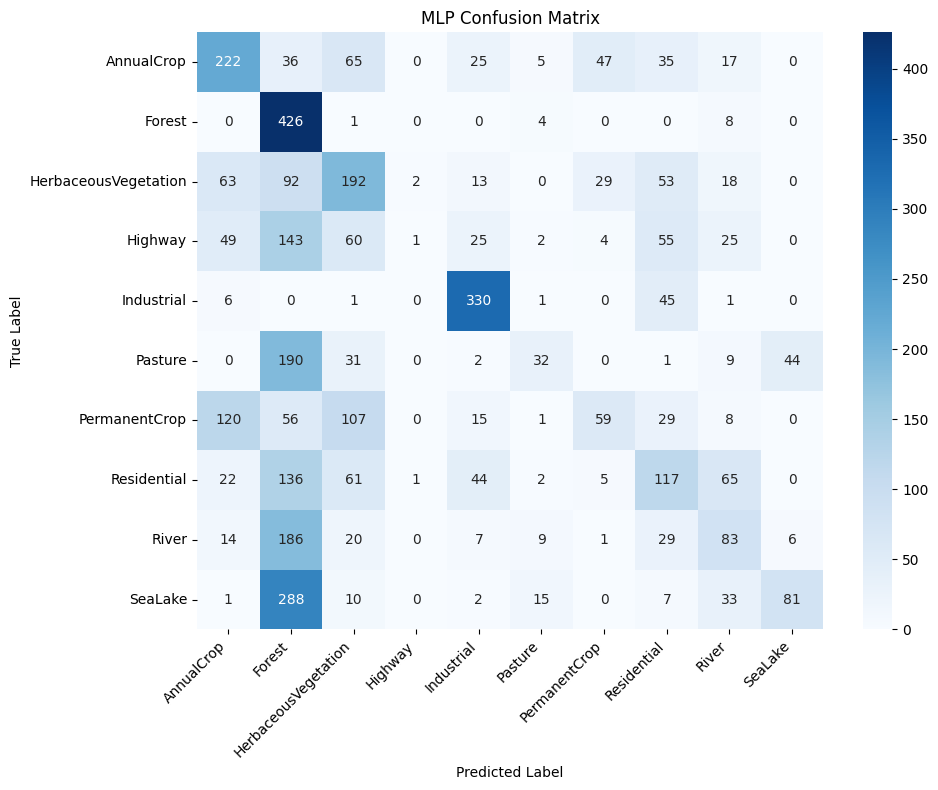

In [14]:

# Define a simple MLP for 64×64×3 inputs

class EuroSAT_MLP(nn.Module):
    def __init__(self, input_dim=3*64*64, hidden_dims=[1024, 512, 256], num_classes=10, dropout_p=0.5):
        super(EuroSAT_MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_p))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch_size, 3, 64, 64)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 3*64*64)
        logits = self.net(x)
        return logits


# Instantiate MLP, loss, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = EuroSAT_MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

# Optional: reuse EarlyStopping class (adjust path)
early_stopper_mlp = EarlyStopping(patience=5, min_delta=1e-4, path='mlp_best.pt')


# Training function for MLP (reusing similar structure)

def train_mlp(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, device):
    train_losses = []
    val_losses   = []
    for epoch in range(1, epochs+1):
        # ---- Training Phase ----
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ---- Validation Phase ----
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                loss = criterion(logits, target)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}/{epochs} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print("MLP Early stopping triggered.")
            break

    # Load best checkpoint
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses


#  Train the MLP

epochs = 30
mlp_train_losses, mlp_val_losses = train_mlp(
    epochs,
    mlp_model,
    optimizer,
    criterion,
    train_loader,
    validation_loader,
    early_stopper_mlp,
    device
)


# Plot Training vs. Validation Loss Curves

plt.figure(figsize=(8, 5))
plt.plot(mlp_train_losses, label='Training Loss')
plt.plot(mlp_val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP: Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluate MLP on test set

mlp_model.eval()
test_loss_mlp = 0.0
correct_mlp   = 0
total_mlp     = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logits       = mlp_model(data)
        loss         = criterion(logits, target)
        test_loss_mlp += loss.item()
        preds = logits.argmax(dim=1)
        correct_mlp += (preds == target).sum().item()
        total_mlp += target.size(0)

avg_test_loss_mlp = test_loss_mlp / len(test_loader)
test_acc_mlp      = correct_mlp / total_mlp
print(f"MLP Test Loss: {avg_test_loss_mlp:.4f}")
print(f"MLP Test Accuracy: {test_acc_mlp * 100:.2f}%")


# Compute F1, classification report, confusion matrix for MLP

all_preds_mlp = []
all_labels_mlp = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logits       = mlp_model(data)
        preds        = logits.argmax(dim=1)
        all_preds_mlp.append(preds.cpu().numpy())
        all_labels_mlp.append(target.cpu().numpy())

y_pred_mlp = np.concatenate(all_preds_mlp)
y_true_mlp = np.concatenate(all_labels_mlp)

f1_macro_mlp = f1_score(y_true_mlp, y_pred_mlp, average='macro')
print(f"\nMLP Macro-Averaged F1 Score: {f1_macro_mlp:.4f}\n")

class_names = full_dataset.classes
report_mlp = classification_report(y_true_mlp, y_pred_mlp, target_names=class_names, digits=4)
print("MLP Classification Report:")
print(report_mlp)

cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
print("MLP Confusion Matrix:")
print(cm_mlp)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MLP Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bonus Task 2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


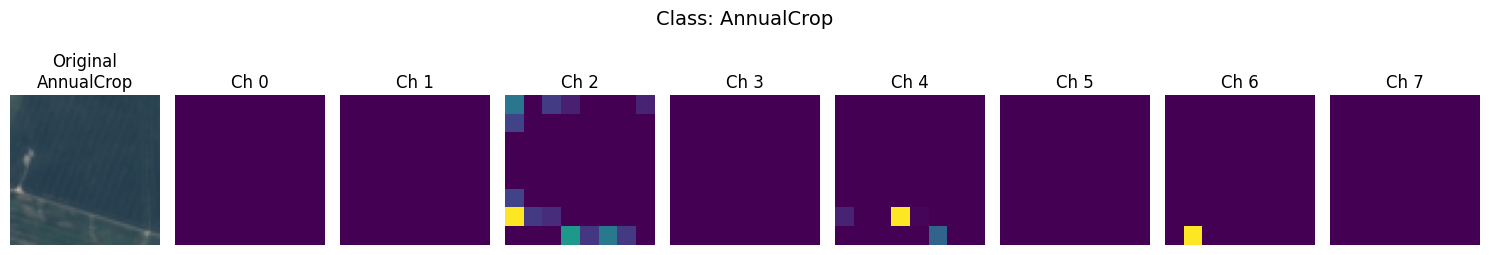

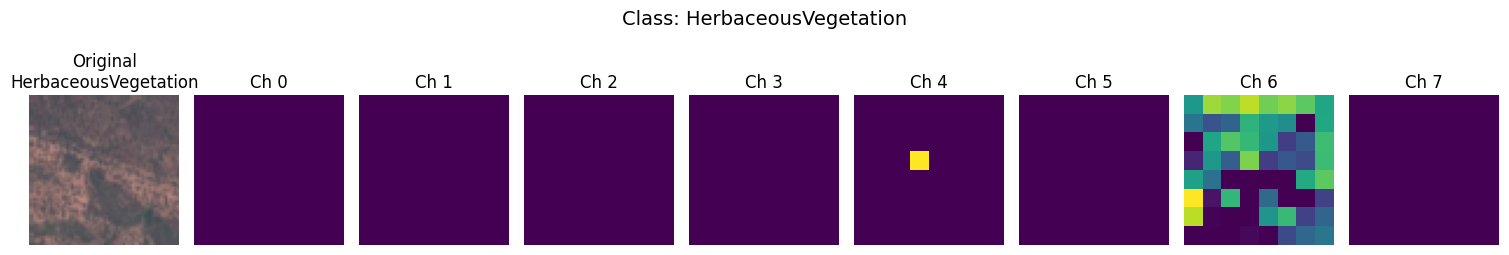

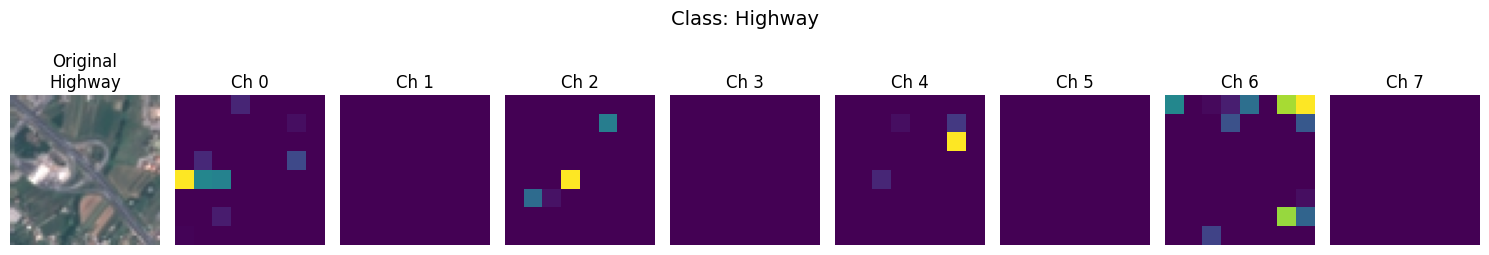

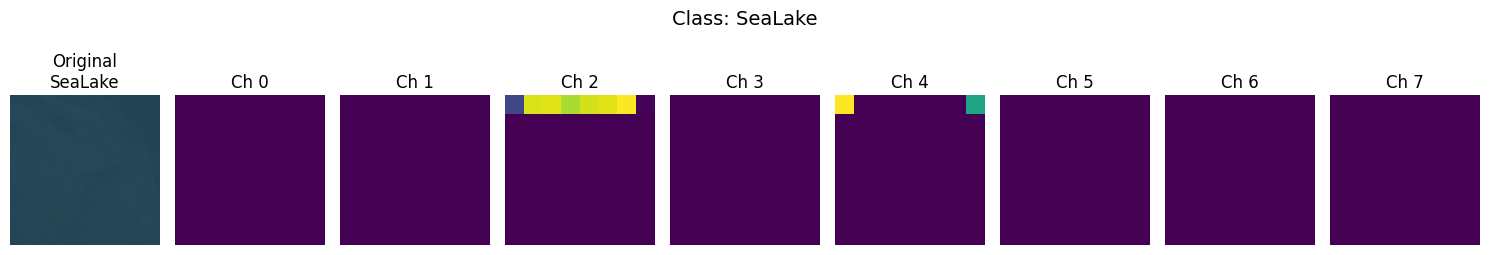

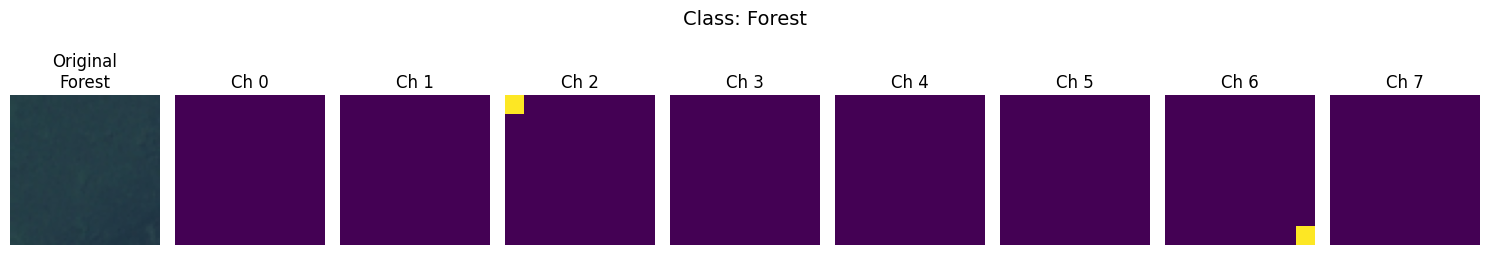

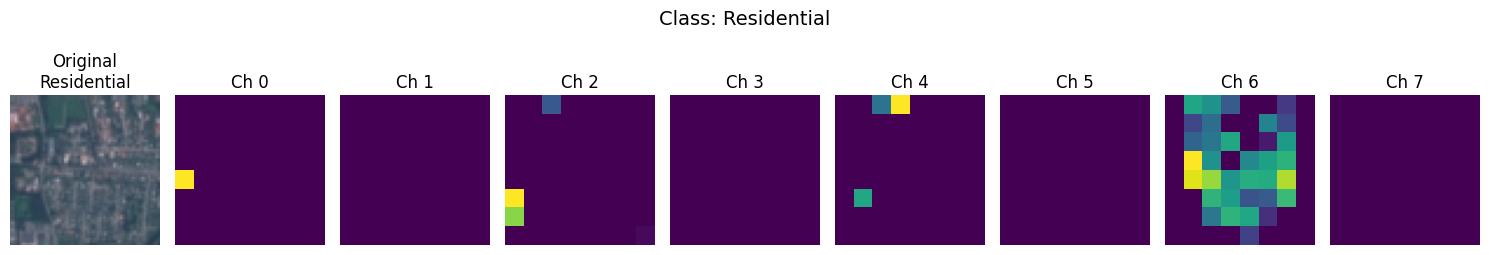

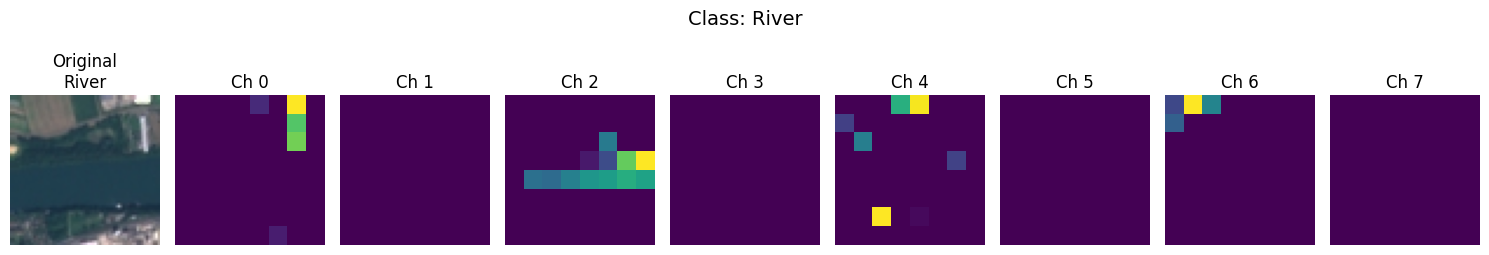

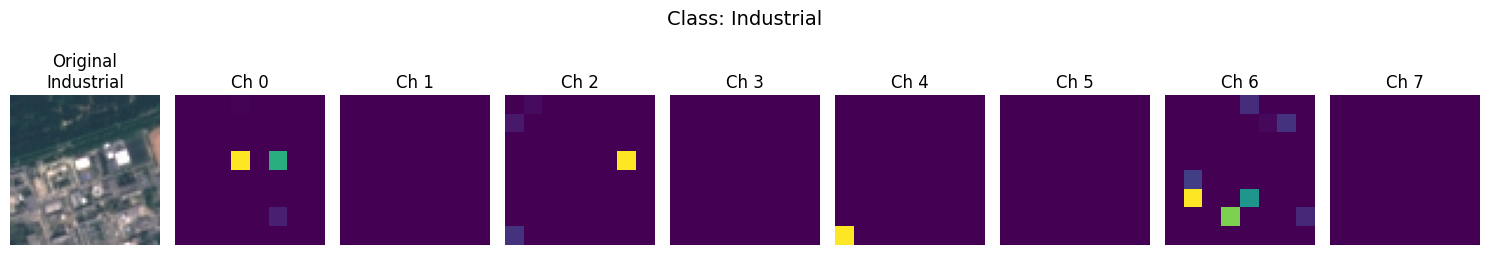

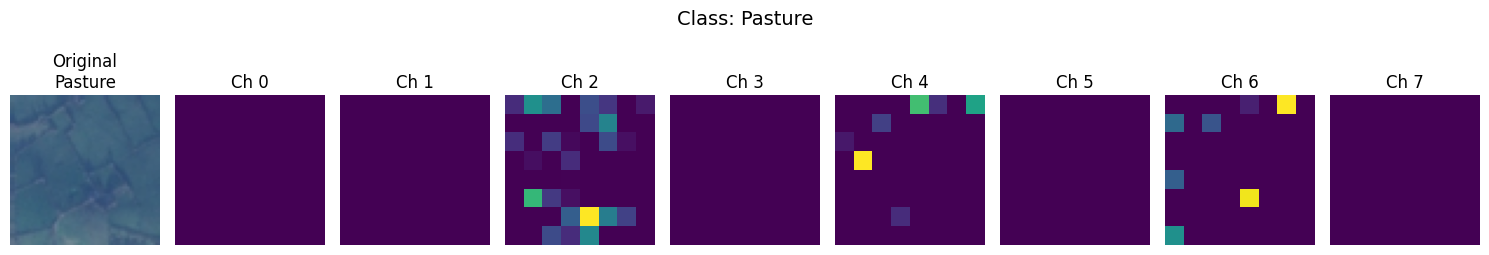

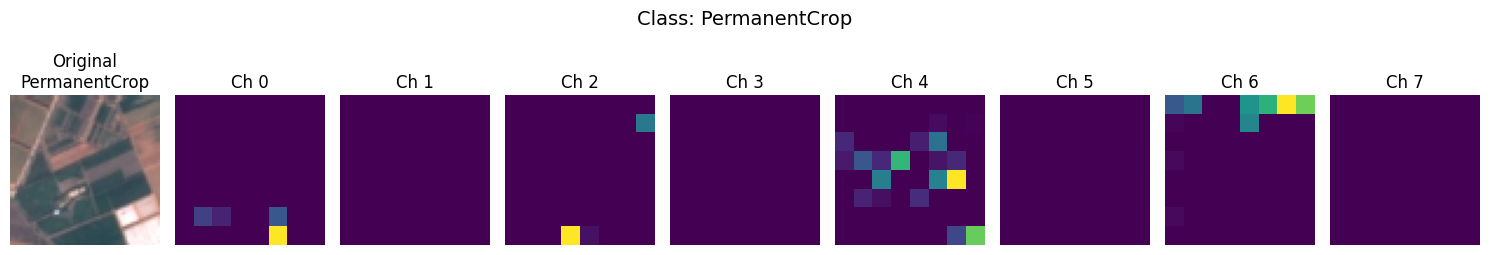

Macro F1: 0.8781

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.8747    0.8805    0.8776       452
              Forest     0.9353    0.9886    0.9612       439
HerbaceousVegetation     0.8259    0.8009    0.8132       462
             Highway     0.8536    0.7527    0.8000       364
          Industrial     0.9412    0.9167    0.9288       384
             Pasture     0.8746    0.8123    0.8423       309
       PermanentCrop     0.7500    0.7975    0.7730       395
         Residential     0.9148    0.9713    0.9422       453
               River     0.8470    0.8732    0.8599       355
             SeaLake     0.9862    0.9794    0.9828       437

            accuracy                         0.8820      4050
           macro avg     0.8803    0.8773    0.8781      4050
        weighted avg     0.8820    0.8820    0.8813      4050



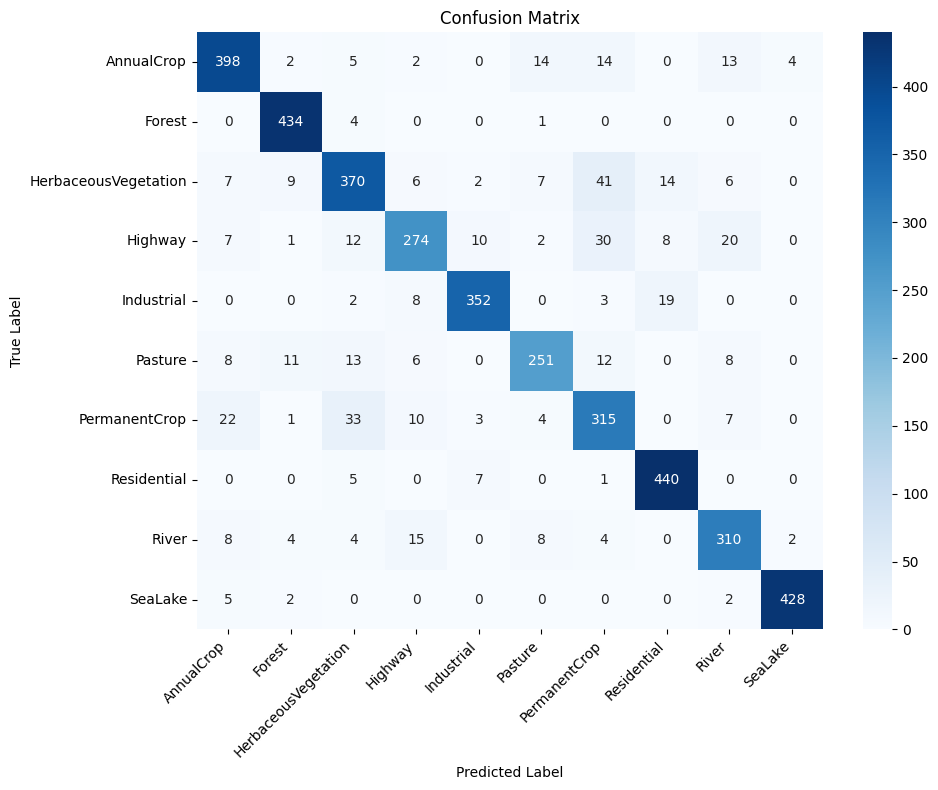

In [15]:

# Register a forward hook on the last MaxPool2d (index 16)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    return hook

# In your EuroSAT_CNN definition, the last MaxPool2d is at features[16]
layer_index = 16
eurosat_model.features[layer_index].register_forward_hook(get_activation('last_pool'))


# Collect one test image per class (same as before)

sampled_images = {}
for data, target in test_loader:
    for img, lbl in zip(data, target):
        cls_idx = lbl.item()
        if cls_idx not in sampled_images:
            sampled_images[cls_idx] = img.unsqueeze(0).to(device)
        if len(sampled_images) == len(full_dataset.classes):
            break
    if len(sampled_images) == len(full_dataset.classes):
        break


# Forward each sample → grab activation['last_pool'] (shape: 128×8×8)
#    Plot original plus first 8 channels

for cls_idx, img_tensor in sampled_images.items():
    _ = eurosat_model(img_tensor)
    featmaps = activation['last_pool'][0]   # (128, 8, 8)

    n_channels = 8
    fig, axes = plt.subplots(1, n_channels + 1, figsize=(15, 3))

    # a) Original image ([-1,1] → [0,1])
    img_disp = (img_tensor.cpu().squeeze().permute(1,2,0).numpy() + 1.0) / 2.0
    axes[0].imshow(img_disp)
    axes[0].set_title(f"Original\n{full_dataset.classes[cls_idx]}")
    axes[0].axis('off')

    # b) First 8 activation channels
    for i in range(n_channels):
        axes[i+1].imshow(featmaps[i], cmap='viridis')
        axes[i+1].set_title(f"Ch {i}")
        axes[i+1].axis('off')

    plt.suptitle(f"Class: {full_dataset.classes[cls_idx]}", fontsize=14)
    plt.tight_layout()
    plt.show()
